# Language Detection Testing

This notebook tests our hybrid language detection system that combines word-list based detection with DeepSeek model backup for ambiguous cases.

## Setup and Imports

First, we'll set up our environment and import necessary modules.

In [1]:
# First cell - Setup and Imports
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set up project paths
import sys
from pathlib import Path
import os

# Define root paths - this is our main project directory
DRIVE_PATH = Path("/content/drive/My Drive/E-commerce_Analysis").resolve()

# Add project root to Python path for package imports
if str(DRIVE_PATH) not in sys.path:
    sys.path.insert(0, str(DRIVE_PATH))

print("\nPython path:")
for p in sys.path[:5]:
    print(f"- {p}")

# Verify our new directory structure
print("\nVerifying directory structure:")
expected_structure = {
    'language_dir': DRIVE_PATH / 'vectorshop/data/language',
    'models_dir': DRIVE_PATH / 'vectorshop/data/language/models',
    'base.py': DRIVE_PATH / 'vectorshop/data/language/base.py',
    'test_processing.py': DRIVE_PATH / 'vectorshop/data/language/utils/text_processing.py',
    'word_list.py': DRIVE_PATH / 'vectorshop/data/language/models/word_list.py',
    'deepseek.py': DRIVE_PATH / 'vectorshop/data/language/models/deepseek.py',
    'google.py': DRIVE_PATH / 'vectorshop/data/language/models/google.py'
}

for name, path in expected_structure.items():
    print(f"{name}: {'✓' if path.exists() else '✗'} ({path})")

Mounted at /content/drive

Python path:
- /content/drive/My Drive/E-commerce_Analysis
- /content
- /env/python
- /usr/lib/python311.zip
- /usr/lib/python3.11

Verifying directory structure:
language_dir: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/language)
models_dir: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/language/models)
base.py: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/language/base.py)
test_processing.py: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/language/utils/text_processing.py)
word_list.py: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/language/models/word_list.py)
deepseek.py: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/language/models/deepseek.py)
google.py: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/language/models/google.py)


In [ ]:
# Second cell - Data Paths and Verification
# Set up project structure paths
VECTORSHOP_PATH = DRIVE_PATH / 'vectorshop'
DATA_PATH = DRIVE_PATH / 'data'  # This is for our raw data
RAW_DATA_PATH = DATA_PATH / 'raw'
LANGUAGE_PATH = VECTORSHOP_PATH / 'data/language'
PROCESSED_DATA_DIR = DRIVE_PATH / 'data' / 'processed'

# Verify paths
print("\nChecking project structure:")
print(f"Vectorshop path exists: {VECTORSHOP_PATH.exists()}")
print(f"Data path exists: {DATA_PATH.exists()}")
print(f"Raw data path exists: {RAW_DATA_PATH.exists()}")
print(f"Language modules path exists: {LANGUAGE_PATH.exists()}")
print(f"Processed data path exists: {PROCESSED_DATA_DIR.exists()}")

# List available data files
print("\nAvailable data files:")
for file in RAW_DATA_PATH.glob('*.csv'):
    print(f"- {file.name}")

# List available language detection modules
print("\nAvailable language detection modules:")
if LANGUAGE_PATH.exists():
    for file in (LANGUAGE_PATH / 'models').glob('*.py'):
        print(f"- {file.name}")


Checking project structure:
Vectorshop path exists: True
Data path exists: True
Raw data path exists: True
Language modules path exists: True
Processed data path exists: True

Available data files:
- olist_geolocation_dataset.csv
- olist_order_payments_dataset.csv
- olist_order_items_dataset.csv
- olist_customers_dataset.csv
- olist_order_reviews_dataset.csv
- olist_sellers_dataset.csv
- product_category_name_translation.csv
- olist_orders_dataset.csv
- olist_products_dataset.csv

Available language detection modules:
- __init__.py
- google.py
- deepseek.py
- word_list.py


In [ ]:
# Install required packages
!pip install transformers torch accelerate

# Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import time
from pathlib import Path
import pandas as pd

# Check if we have GPU access
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

GPU available: True
GPU device: Tesla T4


In [2]:
# First, check our directory structure
import os

def print_directory_structure(path, prefix=""):
    """Print the directory structure to verify our setup"""
    print(f"{prefix}└── {os.path.basename(path)}/")
    if os.path.isdir(path):
        for item in os.listdir(path):
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                print_directory_structure(item_path, prefix + "    ")
            else:
                print(f"{prefix}    └── {item}")

# Print our current structure
print("Current Directory Structure:")
print_directory_structure(DRIVE_PATH)

Current Directory Structure:
└── E-commerce_Analysis/
    └── vectorshop/
        └── embedding/
            └── __pycache__/
                └── __init__.cpython-311.pyc
                └── vector_search.cpython-311.pyc
            └── __init__.py
            └── vector_search.py
        └── search/
            └── __init__.py
        └── __init__.py
        └── storage/
            └── __init__.py
        └── __pycache__/
            └── __init__.cpython-311.pyc
            └── config.cpython-311.pyc
        └── data/
            └── load.py
            └── __pycache__/
                └── load.cpython-311.pyc
                └── deep_detector.cpython-311.pyc
                └── extraction.cpython-311.pyc
                └── sentiment.cpython-311.pyc
                └── rerank_utils.cpython-311.pyc
                └── multimodal.cpython-311.pyc
                └── __init__.cpython-311.pyc
                └── preprocessing.cpython-311.pyc
                └── language_detection.cpython

In [ ]:
# Check for required Python files
required_files = {
    'language_detection.py': VECTORSHOP_PATH / 'data' / 'language_detection.py',
    'preprocessing.py': VECTORSHOP_PATH / 'data' / 'preprocessing.py',
    'load.py': VECTORSHOP_PATH / 'data' / 'load.py',
    '__init__.py': VECTORSHOP_PATH / 'data' / '__init__.py'
}

print("\nChecking for required files:")
for file_name, file_path in required_files.items():
    exists = file_path.exists()
    print(f"{file_name}: {'✓' if exists else '✗'} ({file_path})")


Checking for required files:
language_detection.py: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/language_detection.py)
preprocessing.py: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/preprocessing.py)
load.py: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/load.py)
__init__.py: ✓ (/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/__init__.py)


In [ ]:
import sys

VECTORSHOP_PACKAGE_PATH = VECTORSHOP_PATH / "vectorshop"

# Add the vectorshop package directory to Python path
if str(VECTORSHOP_PACKAGE_PATH) not in sys.path:
    sys.path.insert(0, str(VECTORSHOP_PACKAGE_PATH))
    print(f"Added {VECTORSHOP_PACKAGE_PATH} to Python path")

# Verify Python can find our modules
print("\nPython path includes:")
for path in sys.path:
    print(f"- {path}")

# Try importing again
try:
    from data.language_detection import SmartLanguageDetector  # Adjusted import path
    print("\nSuccessfully imported SmartLanguageDetector")
except ImportError as e:
    print(f"\nImport failed: {str(e)}")
    print("Please verify:")
    print("1. The directory 'vectorshop/vectorshop' contains '__init__.py'")
    print("2. The file paths in the notebook match the directory structure")

Added /content/drive/My Drive/E-commerce_Analysis/vectorshop/vectorshop to Python path

Python path includes:
- /content/drive/My Drive/E-commerce_Analysis/vectorshop/vectorshop
- /content/drive/My Drive/E-commerce_Analysis
- /content
- /env/python
- /usr/lib/python311.zip
- /usr/lib/python3.11
- /usr/lib/python3.11/lib-dynload
- 
- /usr/local/lib/python3.11/dist-packages
- /usr/lib/python3/dist-packages
- /usr/local/lib/python3.11/dist-packages/IPython/extensions
- /usr/local/lib/python3.11/dist-packages/setuptools/_vendor
- /root/.ipython
- /tmp/tmp_498lib3

Import failed: No module named 'data.language_detection'
Please verify:
1. The directory 'vectorshop/vectorshop' contains '__init__.py'
2. The file paths in the notebook match the directory structure


In [ ]:
import sys

# Add the parent directory of vectorshop to Python path
if str(DRIVE_PATH) not in sys.path:
    sys.path.insert(0, str(DRIVE_PATH))
    print(f"Added {DRIVE_PATH} to Python path")

# Verify Python can find our modules
print("\nPython path includes:")
for path in sys.path:
    print(f"- {path}")

# Try importing again
try:
    from vectorshop.data.language_detection import SmartLanguageDetector
    print("\nSuccessfully imported SmartLanguageDetector")
except ImportError as e:
    print(f"\nImport failed: {str(e)}")
    print("Please check if all Python files are in the correct locations")


Python path includes:
- /content/drive/My Drive/E-commerce_Analysis/vectorshop/vectorshop
- /content/drive/My Drive/E-commerce_Analysis
- /content
- /env/python
- /usr/lib/python311.zip
- /usr/lib/python3.11
- /usr/lib/python3.11/lib-dynload
- 
- /usr/local/lib/python3.11/dist-packages
- /usr/lib/python3/dist-packages
- /usr/local/lib/python3.11/dist-packages/IPython/extensions
- /usr/local/lib/python3.11/dist-packages/setuptools/_vendor
- /root/.ipython
- /tmp/tmp_498lib3

Successfully imported SmartLanguageDetector


In [ ]:
def ensure_file_exists(file_path, content=""):
    """Create file if it doesn't exist"""
    if not file_path.exists():
        file_path.parent.mkdir(parents=True, exist_ok=True)
        with open(file_path, 'w') as f:
            f.write(content)
        print(f"Created: {file_path}")

# Create __init__.py files if needed
init_files = [
    VECTORSHOP_PATH / '__init__.py',
    VECTORSHOP_PATH / 'data' / '__init__.py'
]

for init_file in init_files:
    ensure_file_exists(init_file)

In [ ]:
import os
from pathlib import Path

# Define path to credentials
GOOGLE_CREDS_PATH = Path("/content/drive/My Drive/E-commerce_Analysis/keys/google-service-account.json")

# Verify credentials exist
if GOOGLE_CREDS_PATH.exists():
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(GOOGLE_CREDS_PATH)
    print("Google Cloud credentials found and set")
else:
    print("Warning: Google Cloud credentials not found at:", GOOGLE_CREDS_PATH)

# Install Google Cloud library if needed
!pip install --quiet google-cloud-translate

Google Cloud credentials found and set


In [ ]:

!nvidia-smi
!pip install -U bitsandbytes



Tue Feb 18 16:48:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
def test_google_detector():
    """Test Google language detection."""
    from vectorshop.data.language.models.google import GoogleLanguageDetector

    detector = GoogleLanguageDetector()

    test_texts = [
        "Hello, how are you?",  # English
        "Olá, como vai você?",  # Portuguese
        "Este produto é muito bom!", # Portuguese
        "This product is great!"  # English
    ]

    print("Testing Google Language Detection:")
    print("=" * 50)
    for text in test_texts:
        try:
            result = detector.detect(text)
            print(f"\nText: {text}")
            print(f"Detected Language: {result.language}")
            print(f"Confidence: {result.confidence:.2f}")
            print(f"Processing Time: {result.processing_time*1000:.2f}ms")
        except Exception as e:
            print(f"Error detecting language for '{text}': {e}")

# Run test
test_google_detector()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.61G [00:00<?, ?B/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/6.62G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Loaded deepseek-ai/DeepSeek-R1-Distill-Qwen-7B with quantization.
Successfully initialized Google Translation client
Testing Google Language Detection:

Text: Hello, how are you?
Detected Language: en
Confidence: 0.99
Processing Time: 112.49ms

Text: Olá, como vai você?
Detected Language: pt
Confidence: 1.00
Processing Time: 63.65ms

Text: Este produto é muito bom!
Detected Language: pt
Confidence: 1.00
Processing Time: 59.07ms

Text: This product is great!
Detected Language: en
Confidence: 1.00
Processing Time: 61.81ms


In [ ]:
# Debug cell - verify package structure
def check_package_structure():
    """Check if all required files and directories exist."""
    base_path = Path("/content/drive/My Drive/E-commerce_Analysis/vectorshop/data/language")

    required_files = [
        'utils/__init__.py',
        'utils/text_processing.py',
        'utils/performance.py',
        'utils/statistics.py',
        'models/__init__.py',
        'tests/__init__.py',
        '__init__.py'
    ]

    print("Checking package structure:")
    for file in required_files:
        path = base_path / file
        print(f"{file}: {'✓' if path.exists() else '✗'}")

check_package_structure()

Checking package structure:
utils/__init__.py: ✓
utils/text_processing.py: ✓
utils/performance.py: ✓
utils/statistics.py: ✓
models/__init__.py: ✓
tests/__init__.py: ✓
__init__.py: ✓


In [ ]:

!pip install --upgrade bitsandbytes


Successfully loaded olist_products_dataset.csv with 32951 rows
Successfully loaded product_category_name_translation.csv with 71 rows
Successfully loaded olist_order_items_dataset.csv with 112650 rows
Successfully loaded olist_order_reviews_dataset.csv with 99224 rows
Using device: cuda


tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Successfully loaded papluca/xlm-roberta-base-language-detection
Successfully initialized Google Translation client

Processing 20 reviews in batches of 5:
Batch 1/4

INFO:language_detection:Detector: word_list
Text: correta não usei o produto não mas parece bom eu comprei um relógio e me mandaram outro melhor do br...
Language: pt
Confidence: 0.81
Processing Time: 0.33ms

INFO:language_detection:Detector: deepseek
Text: correta não usei o produto não mas parece bom eu comprei um relógio e me mandaram outro melhor do br...
Language: pt
Confidence: 0.99
Processing Time: 823.63ms

INFO:language_detection:Detector: google_api
Text: correta não usei o produto não mas parece bom eu comprei um relógio e me mandaram outro melhor do br...
Language: pt
Confidence: 0.98
Processing Time: 150.97ms

INFO:language_detection:Detector: word_list
Text: voltarei a comprar...
Language: unknown
Confidence: 0.00
Processing Time: 0.02ms

INFO:language_detection:Detector: deepseek
Text: voltarei a comprar...
Language: pt
Confidence: 0.99
Processing Time: 23.15ms

INFO:language_detection:Detector: google_api
Text: voltarei a comprar...
Language: pt
Confidence: 1.00
Process

Batch 2/4

INFO:language_detection:Detector: word_list
Text: ...
Language: unknown
Confidence: 0.00
Processing Time: 0.00ms

INFO:language_detection:Detector: deepseek
Text: ...
Language: unknown
Confidence: 0.07
Processing Time: 46.59ms

INFO:language_detection:Detector: google_api
Text: ...
Language: unknown
Confidence: 0.00
Processing Time: 49.80ms

INFO:language_detection:Detector: word_list
Text: ...
Language: unknown
Confidence: 0.00
Processing Time: 0.00ms

INFO:language_detection:Detector: deepseek
Text: ...
Language: unknown
Confidence: 0.07
Processing Time: 9.08ms

INFO:language_detection:Detector: google_api
Text: ...
Language: unknown
Confidence: 0.00
Processing Time: 64.53ms

INFO:language_detection:Detector: word_list
Text: gostei muito do cordão simples e fofo...
Language: pt
Confidence: 0.80
Processing Time: 0.03ms

INFO:language_detection:Detector: deepseek
Text: gostei muito do cordão simples e fofo...
Language: pt
Confidence: 1.00
Processing Time: 16.02ms

INFO:language_detecti

Batch 3/4

INFO:language_detection:Detector: word_list
Text: produto veio direitinho bem embalado e chegou antes do prazo estou muito satisfeita...
Language: pt
Confidence: 0.78
Processing Time: 0.03ms

INFO:language_detection:Detector: deepseek
Text: produto veio direitinho bem embalado e chegou antes do prazo estou muito satisfeita...
Language: pt
Confidence: 1.00
Processing Time: 13.54ms

INFO:language_detection:Detector: google_api
Text: produto veio direitinho bem embalado e chegou antes do prazo estou muito satisfeita...
Language: pt
Confidence: 0.94
Processing Time: 64.30ms

INFO:language_detection:Detector: word_list
Text: entrega rapidíssima foi comprado e no dia seguinte já estava disponível show compra fácil e entrega ...
Language: pt
Confidence: 0.78
Processing Time: 0.09ms

INFO:language_detection:Detector: deepseek
Text: entrega rapidíssima foi comprado e no dia seguinte já estava disponível show compra fácil e entrega ...
Language: pt
Confidence: 1.00
Processing Time: 13.26ms

INFO

Batch 4/4

INFO:language_detection:Detector: word_list
Text: a compra foi realizada facilmente a entrega foi efetuada muito antes do prazo dado o produto já come...
Language: pt
Confidence: 0.80
Processing Time: 0.09ms

INFO:language_detection:Detector: deepseek
Text: a compra foi realizada facilmente a entrega foi efetuada muito antes do prazo dado o produto já come...
Language: pt
Confidence: 1.00
Processing Time: 14.38ms

INFO:language_detection:Detector: google_api
Text: a compra foi realizada facilmente a entrega foi efetuada muito antes do prazo dado o produto já come...
Language: pt
Confidence: 0.92
Processing Time: 51.53ms

INFO:language_detection:Detector: word_list
Text: o produto é simplesde acordo com a imagem e com o preço pagoobrigada satisfeita gostei muito do prod...
Language: pt
Confidence: 0.80
Processing Time: 0.07ms

INFO:language_detection:Detector: deepseek
Text: o produto é simplesde acordo com a imagem e com o preço pagoobrigada satisfeita gostei muito do prod...
Language:

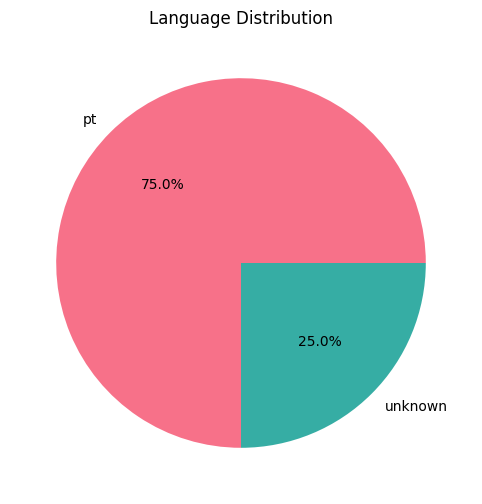

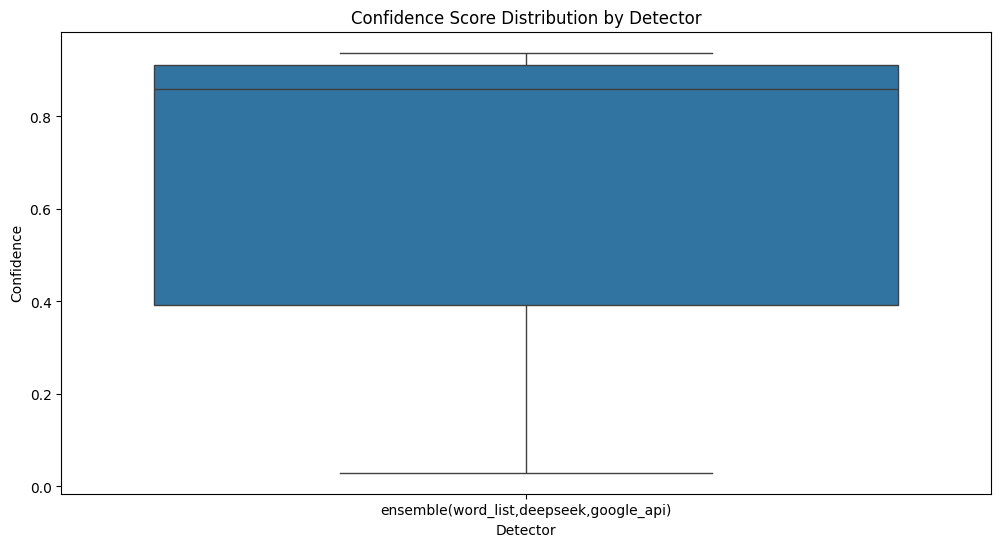

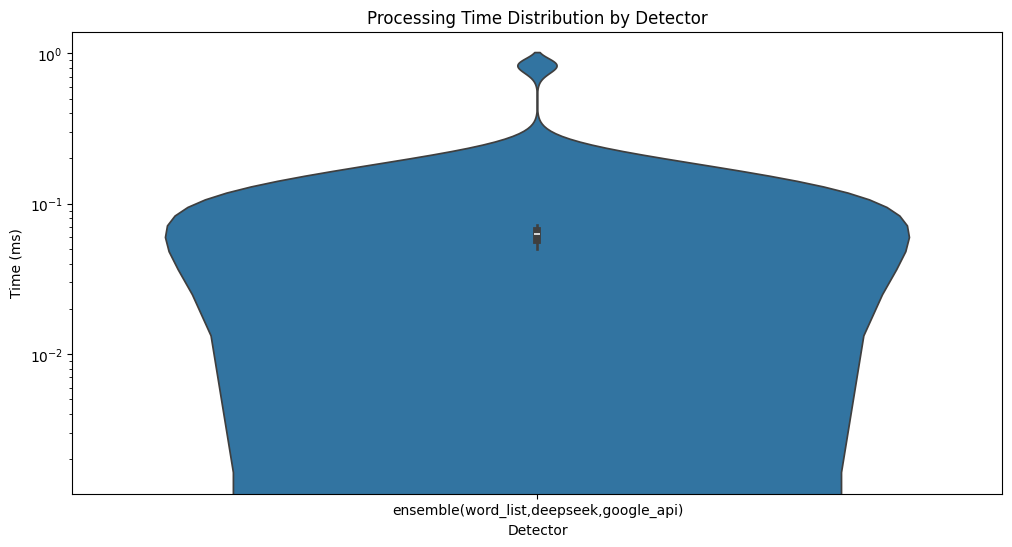



Analysis Results:

Language Distribution:
pt: 15 reviews (75.0%)
unknown: 5 reviews (25.0%)

Detector Usage:
ensemble(word_list,deepseek,google_api): 20 times (100.0%)
Execution time for analyze_real_data: 28448.64ms


In [ ]:
# Analysis cell - Enhanced Implementation
from pathlib import Path
import os
from collections import defaultdict
import time
from vectorshop.config import LANGUAGE_DETECTION, PROCESSED_DATA_DIR, RAW_DATA_DIR, DATA_DIR, PROJECT_ROOT
from vectorshop.data import OlistDataLoader, TextPreprocessor, SmartLanguageDetector
from vectorshop.data.language.utils.ensemble import try_detectors_ensemble
from vectorshop.data.language.models.deepseek import DeepSeekDetector


# Import from language package level
from vectorshop.data.language import (
    clean_text,
    measure_performance,
    get_language_statistics,
    LanguageDetectionLogger,
    LanguageDetectionVisualizer,
    WordListDetector,
    GoogleLanguageDetector
)


@measure_performance
def analyze_real_data(sample_size=100, batch_size=10):
    """
    Analyze language patterns using hybrid detection approach with enhanced logging and visualization.
    """
    # Initialize utilities
    logger = LanguageDetectionLogger(PROCESSED_DATA_DIR / 'logs')
    visualizer = LanguageDetectionVisualizer()

    # Load data
    loader = OlistDataLoader(RAW_DATA_DIR)
    sample_data = loader.get_full_product_data(n_samples=sample_size)

    # Initialize detectors
    word_list_detector = WordListDetector()
    deepseek_detector = DeepSeekDetector(config=LANGUAGE_DETECTION['deepseek'])
    google_detector = GoogleLanguageDetector()

    # Initialize results container with enhanced tracking
    results = {
        'language_counts': defaultdict(int),
        'method_counts': defaultdict(int),
        'processing_times_by_detector': defaultdict(list),
        'confidence_scores_by_detector': defaultdict(list)
    }

    # Process reviews
    reviews = sample_data['review_comment_message'].dropna().tolist()
    total_reviews = len(reviews)

    print(f"\nProcessing {total_reviews} reviews in batches of {batch_size}:")

    for i in range(0, total_reviews, batch_size):
        batch = reviews[i:i + batch_size]
        print(f"\rBatch {i//batch_size + 1}/{(total_reviews-1)//batch_size + 1}", end="")

        for review in batch:
            # Clean text first
            cleaned_review = clean_text(review)

            # Try detectors in sequence with proper logging
            result = try_detectors_ensemble(
                cleaned_review,
                word_list_detector,
                deepseek_detector,
                google_detector,
                logger,
                LANGUAGE_DETECTION
            )


            # Track results
            results['language_counts'][result.language] += 1
            results['method_counts'][result.method_used] += 1
            results['processing_times_by_detector'][result.method_used].append(result.processing_time)
            results['confidence_scores_by_detector'][result.method_used].append(result.confidence)

    # Visualize results
    visualizer.plot_language_distribution(results['language_counts'])
    visualizer.plot_confidence_distribution(results['confidence_scores_by_detector'])
    visualizer.plot_processing_times(results['processing_times_by_detector'])

    # Print summary statistics
    print_summary_statistics(results, total_reviews)

    return results

def print_summary_statistics(results, total_reviews):
    """Print formatted summary statistics."""
    print("\n\nAnalysis Results:")
    print("=" * 50)

    # Language distribution
    print("\nLanguage Distribution:")
    for lang, count in results['language_counts'].items():
        percentage = (count/total_reviews) * 100
        print(f"{lang}: {count} reviews ({percentage:.1f}%)")

    # Method usage
    print("\nDetector Usage:")
    for method, count in results['method_counts'].items():
        percentage = (count/total_reviews) * 100
        print(f"{method}: {count} times ({percentage:.1f}%)")

# Run analysis
if __name__ == "__main__":
    try:
        results = analyze_real_data(sample_size=20, batch_size=5)
    except Exception as e:
        print(f"\nError during analysis: {str(e)}")

In [ ]:
# Debug cell: Investigate unknown texts

# Re-initialize your detectors
word_list_detector = WordListDetector()
deepseek_detector = DeepSeekDetector(config=LANGUAGE_DETECTION['deepseek'])
google_detector = GoogleLanguageDetector()

# Load or sample your reviews
loader = OlistDataLoader(RAW_DATA_DIR)
sample_data = loader.get_full_product_data(n_samples=20)  # or whatever size
reviews = sample_data['review_comment_message'].dropna().tolist()

unknown_texts = []

for review in reviews:
    cleaned = clean_text(review)
    result = try_detectors_ensemble(
        cleaned,
        word_list_detector,
        deepseek_detector,
        google_detector,
        None,  # logger can be None if you don't need logging here
        LANGUAGE_DETECTION
    )
    if result.language == "unknown":
        unknown_texts.append(review)

print("\nSample unknown texts:")
for t in unknown_texts[:10]:
    print("-", t)


Using device: cuda
Successfully loaded papluca/xlm-roberta-base-language-detection
Successfully initialized Google Translation client
Successfully loaded olist_products_dataset.csv with 32951 rows
Successfully loaded product_category_name_translation.csv with 71 rows
Successfully loaded olist_order_items_dataset.csv with 112650 rows
Successfully loaded olist_order_reviews_dataset.csv with 99224 rows

Sample unknown texts:
- 
- 
- 
- 
- 


In [ ]:
# example_integration.py

import pandas as pd
from vectorshop.data.load import OlistDataLoader
from vectorshop.data.language import LanguageDetectionLogger, LanguageDetectionResult
from vectorshop.data.language.utils.ensemble import try_detectors_ensemble
from vectorshop.data.language.models.deepseek import DeepSeekDetector
from vectorshop.data.language import WordListDetector, GoogleLanguageDetector, clean_text
from vectorshop.config import LANGUAGE_DETECTION, RAW_DATA_DIR, PROCESSED_DATA_DIR
from vectorshop.data.preprocessing import MultilingualTextPreprocessor, ProcessedText

def run_preprocessing_and_detection(sample_size=20, handle_empty=True):
    """
    Demonstrates how to preprocess Olist data using MultilingualTextPreprocessor
    and then apply ensemble language detection, optionally skipping empty texts.
    """

    # 1. Load Olist data
    loader = OlistDataLoader(RAW_DATA_DIR)
    sample_data = loader.get_full_product_data(n_samples=sample_size)

    # 2. Prepare detectors
    logger = LanguageDetectionLogger(PROCESSED_DATA_DIR / 'logs')
    word_list_detector = WordListDetector()
    deepseek_detector = DeepSeekDetector(config=LANGUAGE_DETECTION['deepseek'])
    google_detector = GoogleLanguageDetector()

    # 3. Initialize the multilingual preprocessor
    preprocessor = MultilingualTextPreprocessor(
        remove_accents=False,  # Keep accents for better multilingual detection
        remove_special_chars=True,
        min_length=2           # Lower to 2 if you want to keep short words like "ok"
    )

    # Store results
    processed_reviews = []
    final_results = []

    # 4. Preprocess each review
    for idx, row in sample_data.iterrows():
        review_text = row.get('review_comment_message', '')

        # Use the new metadata-based processing
        processed_obj: ProcessedText = preprocessor.process_with_metadata(review_text)

        # Optionally skip empty or near-empty text
        if handle_empty and not processed_obj.cleaned.strip():
            # Mark it as "no_content" or skip detection
            final_results.append(LanguageDetectionResult(
                text=review_text,
                language="no_content",
                confidence=0.0,
                method_used="skip",
                processing_time=0.0
            ))
            processed_reviews.append(processed_obj)
            continue

        # 5. If text is not empty, run ensemble detection
        # You can pass either the original or the cleaned text
        # Here, we pass the cleaned text for better detection
        detection_result = try_detectors_ensemble(
            processed_obj.cleaned,
            word_list_detector,
            deepseek_detector,
            google_detector,
            logger,
            LANGUAGE_DETECTION
        )

        final_results.append(detection_result)
        processed_reviews.append(processed_obj)

    # 6. Convert results into a DataFrame for analysis
    # Combine the metadata from ProcessedText with detection results
    out_data = []
    for p_obj, det_res in zip(processed_reviews, final_results):
        out_data.append({
            "original_review": p_obj.original,
            "cleaned_review": p_obj.cleaned,
            "preprocessor_language_guess": p_obj.language,   # from MultilingualTextPreprocessor
            "ensemble_language": det_res.language,          # from ensemble
            "confidence": det_res.confidence,
            "has_accents": p_obj.has_accents,
            "word_count": p_obj.word_count,
            "method_used": det_res.method_used
        })

    df_results = pd.DataFrame(out_data)

    # 7. Return or print the DataFrame
    return df_results

# Example usage:
if __name__ == "__main__":
    df_results = run_preprocessing_and_detection(sample_size=20, handle_empty=True)
    print("\nPreview of processed detection results:")
    print(df_results.head(10))


Successfully loaded olist_products_dataset.csv with 32951 rows
Successfully loaded product_category_name_translation.csv with 71 rows
Successfully loaded olist_order_items_dataset.csv with 112650 rows
Successfully loaded olist_order_reviews_dataset.csv with 99224 rows
Using device: cuda


INFO:language_detection:Detector: word_list
Text: correta usei produto mas parece bom eu comprei um rel gio me mandaram outro melhor do brasil vou com...
Language: pt
Confidence: 0.66
Processing Time: 0.07ms

INFO:language_detection:Detector: deepseek
Text: correta usei produto mas parece bom eu comprei um rel gio me mandaram outro melhor do brasil vou com...
Language: pt
Confidence: 1.00
Processing Time: 11.60ms

INFO:language_detection:Detector: google_api
Text: correta usei produto mas parece bom eu comprei um rel gio me mandaram outro melhor do brasil vou com...
Language: pt
Confidence: 0.98
Processing Time: 93.17ms



Successfully loaded papluca/xlm-roberta-base-language-detection
Successfully initialized Google Translation client


INFO:language_detection:Detector: word_list
Text: voltarei comprar...
Language: unknown
Confidence: 0.00
Processing Time: 0.01ms

INFO:language_detection:Detector: deepseek
Text: voltarei comprar...
Language: pt
Confidence: 0.54
Processing Time: 10.92ms

INFO:language_detection:Detector: google_api
Text: voltarei comprar...
Language: pt
Confidence: 1.00
Processing Time: 67.53ms

INFO:language_detection:Detector: word_list
Text: recebi metade do pedido nao recebi lustre ainda...
Language: pt
Confidence: 0.70
Processing Time: 0.02ms

INFO:language_detection:Detector: deepseek
Text: recebi metade do pedido nao recebi lustre ainda...
Language: pt
Confidence: 1.00
Processing Time: 9.89ms

INFO:language_detection:Detector: google_api
Text: recebi metade do pedido nao recebi lustre ainda...
Language: pt
Confidence: 1.00
Processing Time: 60.97ms

INFO:language_detection:Detector: word_list
Text: correto...
Language: pt
Confidence: 0.70
Processing Time: 0.01ms

INFO:language_detection:Detector:


Preview of processed detection results:
                                     original_review  \
0  correta  | não usei o produto não mas parece b...   
1                                Voltarei a comprar!   
2  Recebi a metade do pedido. Nao recebi o lustre...   
3                                            correto   
4  A entrega foi direitinha, mas o produto é péss...   
5                A loja mandou bem.obrigado. ronaldo   
6                             Entrega antes do Prazo   
7                                                      
8                                                      
9            Gostei muito do cordão! Simples e fofo!   

                                      cleaned_review  \
0  correta usei produto mas parece bom eu comprei...   
1                                   voltarei comprar   
2    recebi metade do pedido nao recebi lustre ainda   
3                                            correto   
4  entrega foi direitinha mas produto ssimo embal...   
5     

In [ ]:
import pandas as pd
from pathlib import Path
from vectorshop.data.load import OlistDataLoader
from vectorshop.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, LANGUAGE_DETECTION
from vectorshop.data.preprocessing import MultilingualTextPreprocessor, ProcessedText, create_product_text
from vectorshop.data.language.utils.ensemble import try_detectors_ensemble
from vectorshop.data.language import LanguageDetectionLogger, WordListDetector, GoogleLanguageDetector, clean_text
from vectorshop.data.language.models.deepseek import DeepSeekDetector

def preprocess_and_save(sample_size=100,
                        output_csv="/content/drive/My Drive/E-commerce_Analysis/data/processed/processed_products.csv",
                        min_review_word_count=3):
    """
    Preprocess product data from the Olist dataset, enrich it with price information,
    merge review text and product category into a combined textual field, and save the output.

    Args:
        sample_size (int): Number of products to process.
        output_csv (str): File path to save the processed CSV.
        min_review_word_count (int): Minimum word count required for a review to be considered valid.
    """
    # Load raw data using OlistDataLoader (this returns products merged with reviews)
    loader = OlistDataLoader(RAW_DATA_DIR)
    data = loader.get_full_product_data(n_samples=sample_size)

    # Load order items data to get price information
    order_items_path = Path(RAW_DATA_DIR) / "olist_order_items_dataset.csv"
    order_items_df = pd.read_csv(order_items_path)
    # Group by product_id to compute average price if multiple entries exist
    order_items_price = order_items_df[['product_id', 'price']].groupby('product_id', as_index=False).mean()

    # Merge the price information into the main data on 'product_id'
    data = data.merge(order_items_price, on='product_id', how='left')

    # Create a new combined textual field using available columns.
    # Since there's no real product description, we combine product category and review text.
    def create_combined_text(row):
        parts = []
        if row.get("product_category_name"):
            parts.append(f"category: {row.get('product_category_name')}")
        # Optionally, include product id or name if needed (here we use product_id as identifier)
        if row.get("product_id"):
            parts.append(f"product_id: {row.get('product_id')}")
        # Use review_comment_message if available from the merged reviews
        if row.get("review_comment_message"):
            parts.append(f"review: {row.get('review_comment_message')}")
        return " | ".join(parts)

    data["combined_text"] = data.apply(create_combined_text, axis=1)

    # Initialize preprocessor and language detection tools
    preprocessor = MultilingualTextPreprocessor(remove_accents=False, min_length=2)
    logger = LanguageDetectionLogger(PROCESSED_DATA_DIR / 'logs')
    word_list_detector = WordListDetector()
    deepseek_detector = DeepSeekDetector(config=LANGUAGE_DETECTION['deepseek'])
    google_detector = GoogleLanguageDetector()

    processed_rows = []
    for idx, row in data.iterrows():
        # Use the combined_text field for embedding purposes
        combined_text = row.get("combined_text", "")

        # Process text with metadata
        processed_obj = preprocessor.process_with_metadata(combined_text)

        # If the cleaned text is empty or too short, mark it as "no_content"
        if processed_obj.word_count < min_review_word_count:
            detected_language = "no_content"
            confidence = 0.0
            method_used = "skip"
        else:
            detection_result = try_detectors_ensemble(
                processed_obj.cleaned,
                word_list_detector,
                deepseek_detector,
                google_detector,
                logger,
                LANGUAGE_DETECTION
            )
            detected_language = detection_result.language
            confidence = detection_result.confidence
            method_used = detection_result.method_used

        processed_rows.append({
            "product_id": row.get("product_id"),
            "original_text": processed_obj.original,
            "cleaned_text": processed_obj.cleaned,
            "preprocessor_language": processed_obj.language,
            "detected_language": detected_language,
            "confidence": confidence,
            "price": row.get("price"),  # Populated from the merge
            "word_count": processed_obj.word_count
        })

    df_processed = pd.DataFrame(processed_rows)
    df_processed.to_csv(output_csv, index=False)
    print(f"Processed data saved to {output_csv}")
    return df_processed

if __name__ == "__main__":
    df_results = preprocess_and_save(sample_size=200,
                                     output_csv="/content/drive/My Drive/E-commerce_Analysis/data/processed/processed_products.csv",
                                     min_review_word_count=3)
    print(df_results.head(10))


Successfully loaded olist_products_dataset.csv with 32951 rows
Successfully loaded product_category_name_translation.csv with 71 rows
Successfully loaded olist_order_items_dataset.csv with 112650 rows
Successfully loaded olist_order_reviews_dataset.csv with 99224 rows
Using device: cuda


INFO:language_detection:Detector: word_list
Text: category relogios presentes product id f819f0c84a64f02d3a5606ca95edd272 review correta usei produto ...
Language: pt
Confidence: 0.66
Processing Time: 0.07ms

INFO:language_detection:Detector: deepseek
Text: category relogios presentes product id f819f0c84a64f02d3a5606ca95edd272 review correta usei produto ...
Language: pt
Confidence: 1.00
Processing Time: 12.91ms

INFO:language_detection:Detector: google_api
Text: category relogios presentes product id f819f0c84a64f02d3a5606ca95edd272 review correta usei produto ...
Language: pt
Confidence: 0.98
Processing Time: 90.02ms



Successfully loaded papluca/xlm-roberta-base-language-detection
Successfully initialized Google Translation client


INFO:language_detection:Detector: word_list
Text: category utilidades domesticas product id b9de40e43fccb6ba53b7eadbd5c49077 review voltarei comprar...
Language: unknown
Confidence: 0.00
Processing Time: 0.02ms

INFO:language_detection:Detector: deepseek
Text: category utilidades domesticas product id b9de40e43fccb6ba53b7eadbd5c49077 review voltarei comprar...
Language: pt
Confidence: 0.60
Processing Time: 13.35ms

INFO:language_detection:Detector: google_api
Text: category utilidades domesticas product id b9de40e43fccb6ba53b7eadbd5c49077 review voltarei comprar...
Language: pt
Confidence: 0.81
Processing Time: 61.31ms

INFO:language_detection:Detector: word_list
Text: category moveis decoracao product id 26afe4ed5890d941fcba14205863eec7 review recebi metade do pedido...
Language: pt
Confidence: 0.70
Processing Time: 0.02ms

INFO:language_detection:Detector: deepseek
Text: category moveis decoracao product id 26afe4ed5890d941fcba14205863eec7 review recebi metade do pedido...
Language: 

Processed data saved to /content/drive/My Drive/E-commerce_Analysis/data/processed/processed_products.csv
                         product_id  \
0  f819f0c84a64f02d3a5606ca95edd272   
1  b9de40e43fccb6ba53b7eadbd5c49077   
2  26afe4ed5890d941fcba14205863eec7   
3  986870b9985d95ef6205bae1953a61a5   
4  28ce57ecf4afba85e6020ec0209cada9   
5  7cb2ff3193293db892fd5697aa99a19b   
6  116a8f521211c179741c051816f2b898   
7  b3e99300a2d0481e7b1d7ce484d498cf   
8  609092e5b5c4a202878eb9ba03b47793   
9  355c91ffac499557d65c0821237b6350   

                                       original_text  \
0  category: relogios_presentes | product_id: f81...   
1  category: utilidades_domesticas | product_id: ...   
2  category: moveis_decoracao | product_id: 26afe...   
3  category: moveis_decoracao | product_id: 98687...   
4  category: cool_stuff | product_id: 28ce57ecf4a...   
5  category: moveis_decoracao | product_id: 7cb2f...   
6  category: cama_mesa_banho | product_id: 116a8f...   
7  category: fas

In [ ]:
!pip install faiss-cpu
!pip install sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 68.5 MB/s eta 0:00:00


In [ ]:
# Import the necessary functions from vector_search.py
from vectorshop.embedding.vector_search import load_processed_data, generate_embeddings, build_faiss_index, search_products

# Step 1: Load processed data (make sure the path is correct)
df = load_processed_data("/content/drive/My Drive/E-commerce_Analysis/data/processed/processed_products.csv")
print("Number of products loaded:", len(df))

# Step 2: Prepare the texts (ensure no NaN values)
texts = df["cleaned_text"].fillna("").astype(str).tolist()

# Step 3: Generate embeddings using a lightweight model
embeddings, model = generate_embeddings(texts, model_name="all-MiniLM-L6-v2")
print("Embeddings shape:", embeddings.shape)

# Step 4: Build the FAISS index from the embeddings
index = build_faiss_index(embeddings)
print("FAISS index contains:", index.ntotal, "vectors")

# Step 5: Manually run a few queries to inspect results
queries = [
    "pink t-shirt with monkey logo in m size",
    "casual shoes for summer",
    "elegant dress with floral pattern",
    "blue jeans for men"
]

for query in queries:
    print("\nQuery:", query)
    results = search_products(query, model, index, df, top_k=5)
    # Print relevant fields from the results
    print(results[["product_id", "original_text", "price", "detected_language", "distance"]])


                         product_id  \
0  f819f0c84a64f02d3a5606ca95edd272   
1  b9de40e43fccb6ba53b7eadbd5c49077   
2  26afe4ed5890d941fcba14205863eec7   
3  986870b9985d95ef6205bae1953a61a5   
4  28ce57ecf4afba85e6020ec0209cada9   

                                       original_text  \
0  category: relogios_presentes | product_id: f81...   
1  category: utilidades_domesticas | product_id: ...   
2  category: moveis_decoracao | product_id: 26afe...   
3  category: moveis_decoracao | product_id: 98687...   
4  category: cool_stuff | product_id: 28ce57ecf4a...   

                                        cleaned_text preprocessor_language  \
0  category relogios presentes product id f819f0c...                    pt   
1  category utilidades domesticas product id b9de...                    en   
2  category moveis decoracao product id 26afe4ed5...                    pt   
3  category moveis decoracao product id 986870b99...                    en   
4  category cool stuff product id 28ce

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings shape: (200, 384)
FAISS index contains: 200 vectors

Query: pink t-shirt with monkey logo in m size
                           product_id  \
135  368ba390a67a37fa114450dc1f19e047   
46   e7f85596b92f92cb501855897696f66b   
189  e13f46cf68d356e0ac0f32058af20911   
161  6401d2f82d6e6c52998ce626fe4eda24   
151  49e70ba5085cd95e69fb041635304a0c   

                                         original_text  price  \
135  category: fashion_bolsas_e_acessorios | produc...   59.9   
46   category: fashion_underwear_e_moda_praia | pro...   62.0   
189  category: fashion_bolsas_e_acessorios | produc...   24.9   
161  category: fashion_roupa_masculina | product_id...   69.9   
151  category: fashion_bolsas_e_acessorios | produc...   23.2   

    detected_language  distance  
135                pt  1.379032  
46                 pt  1.387090  
189                pt  1.410382  
161                pt  1.426542  
151                pt  1.431693  

Query: casual shoes for summer
               

In [ ]:

pd.set_option('display.max_colwidth', None)

# Import necessary functions from vector_search.py and deepseek_rerank.py
from vectorshop.embedding.vector_search import (
    load_processed_data, generate_embeddings, build_faiss_index, search_products,
    filter_by_price, filter_by_category, filter_by_distance
)
from vectorshop.data.language.utils.deepseek_rerank import re_rank_results, tokenizer_deepseek, model_deepseek

# Load processed data, generate embeddings, and build FAISS index as usual
df = load_processed_data("/content/drive/My Drive/E-commerce_Analysis/data/processed/processed_products.csv")
texts = df["cleaned_text"].fillna("").astype(str).tolist()
embeddings, model = generate_embeddings(texts, model_name="all-MiniLM-L6-v2")
index = build_faiss_index(embeddings)

# Run a query
query = "pink t-shirt with monkey logo in m size"
results = search_products(query, model, index, df, top_k=10)
print("Raw search results:")
print(results[["product_id", "original_text", "price", "detected_language", "distance"]])

# Apply additional filtering if needed
results_filtered = filter_by_price(results, 10.0, 50.0)
results_filtered = filter_by_distance(results_filtered, 1.5)
category_list = ["roupa", "t-shirt", "vestido", "jeans", "fashion"]
results_filtered = filter_by_category(results_filtered, category_list)
print("Results after filtering:")
print(results_filtered[["product_id", "original_text", "price", "distance"]])

# Re-rank using DeepSeek model's reasoning
re_ranked_results = re_rank_results(query, results_filtered, tokenizer_deepseek, model_deepseek, top_k=5)
print("Re-ranked results:")
print(re_ranked_results[["product_id", "original_text", "price", "distance"]])

from IPython.display import display, HTML
display(HTML(results_filtered.to_html()))



                         product_id  \
0  f819f0c84a64f02d3a5606ca95edd272   
1  b9de40e43fccb6ba53b7eadbd5c49077   
2  26afe4ed5890d941fcba14205863eec7   
3  986870b9985d95ef6205bae1953a61a5   
4  28ce57ecf4afba85e6020ec0209cada9   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Raw search results:
                           product_id  \
135  368ba390a67a37fa114450dc1f19e047   
46   e7f85596b92f92cb501855897696f66b   
189  e13f46cf68d356e0ac0f32058af20911   
161  6401d2f82d6e6c52998ce626fe4eda24   
151  49e70ba5085cd95e69fb041635304a0c   
7    b3e99300a2d0481e7b1d7ce484d498cf   
49   af64874ef27a7dc357905b75ea78555a   
78   60567eaf5cdf794639e94508ec387a82   
127  b825640a6e030d36a45c34eed447a07a   
53   b1c791ce2fd764b4aaea6b9064b224ac   

                                                                                                                                                                                                                                                                                                                                                                                                   original_text  \
135                                                                                                                         

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Re-ranked results:
                           product_id  \
151  49e70ba5085cd95e69fb041635304a0c   
189  e13f46cf68d356e0ac0f32058af20911   
7    b3e99300a2d0481e7b1d7ce484d498cf   

                                                                                                                                                                                          original_text  \
151                                                                                                                category: fashion_bolsas_e_acessorios | product_id: 49e70ba5085cd95e69fb041635304a0c   
189  category: fashion_bolsas_e_acessorios | product_id: e13f46cf68d356e0ac0f32058af20911 | review: Muito bom! | Fiquei extremamente satisfeita com minha compra!  | entrega antes do prazo, recomendo.   
7                                                                                                                  category: fashion_bolsas_e_acessorios | product_id: b3e99300a2d0481e7b1d7ce484d498cf   

   

,product_id,original_text,cleaned_text,preprocessor_language,detected_language,confidence,price,word_count,distance
189,e13f46cf68d356e0ac0f32058af20911,"category: fashion_bolsas_e_acessorios | product_id: e13f46cf68d356e0ac0f32058af20911 | review: Muito bom! | Fiquei extremamente satisfeita com minha compra! | entrega antes do prazo, recomendo.",category fashion bolsas acessorios product id e13f46cf68d356e0ac0f32058af20911 review muito bom fiquei extremamente satisfeita com minha compra entrega antes do prazo recomendo,en,pt,0.937408,24.9,21,1.410382
151,49e70ba5085cd95e69fb041635304a0c,category: fashion_bolsas_e_acessorios | product_id: 49e70ba5085cd95e69fb041635304a0c,category fashion bolsas acessorios product id 49e70ba5085cd95e69fb041635304a0c,en,pt,0.399467,23.2,7,1.431693
7,b3e99300a2d0481e7b1d7ce484d498cf,category: fashion_bolsas_e_acessorios | product_id: b3e99300a2d0481e7b1d7ce484d498cf,category fashion bolsas acessorios product id b3e99300a2d0481e7b1d7ce484d498cf,en,pt,0.261890,24.9,7,1.472766


In [ ]:
# Assuming you already have the variables: df, model, index from the previous cell
from vectorshop.embedding.vector_search import filter_by_price, search_products

# Example search query
query = "pink t-shirt with monkey logo in m size"
results = search_products(query, model, index, df, top_k=10)
print("Raw search results:")
print(results[["product_id", "original_text", "price", "detected_language", "distance"]])

# Now apply a price filter (e.g., between 10 and 50)
min_price = 10.0
max_price = 50.0
filtered_results = filter_by_price(results, min_price, max_price)
print("\nFiltered search results (price between 10 and 50):")
print(filtered_results[["product_id", "original_text", "price", "detected_language", "distance"]])


Raw search results:
                           product_id  \
135  368ba390a67a37fa114450dc1f19e047   
46   e7f85596b92f92cb501855897696f66b   
189  e13f46cf68d356e0ac0f32058af20911   
161  6401d2f82d6e6c52998ce626fe4eda24   
151  49e70ba5085cd95e69fb041635304a0c   
7    b3e99300a2d0481e7b1d7ce484d498cf   
49   af64874ef27a7dc357905b75ea78555a   
78   60567eaf5cdf794639e94508ec387a82   
127  b825640a6e030d36a45c34eed447a07a   
53   b1c791ce2fd764b4aaea6b9064b224ac   

                                         original_text       price  \
135  category: fashion_bolsas_e_acessorios | produc...   59.900000   
46   category: fashion_underwear_e_moda_praia | pro...   62.000000   
189  category: fashion_bolsas_e_acessorios | produc...   24.900000   
161  category: fashion_roupa_masculina | product_id...   69.900000   
151  category: fashion_bolsas_e_acessorios | produc...   23.200000   
7    category: fashion_bolsas_e_acessorios | produc...   24.900000   
49   category: fashion_bolsas_e_acesso

Distance stats:
count    10.000000
mean      1.461140
std       0.065013
min       1.379032
25%       1.414422
50%       1.452230
75%       1.496611
max       1.572278
Name: distance, dtype: float64


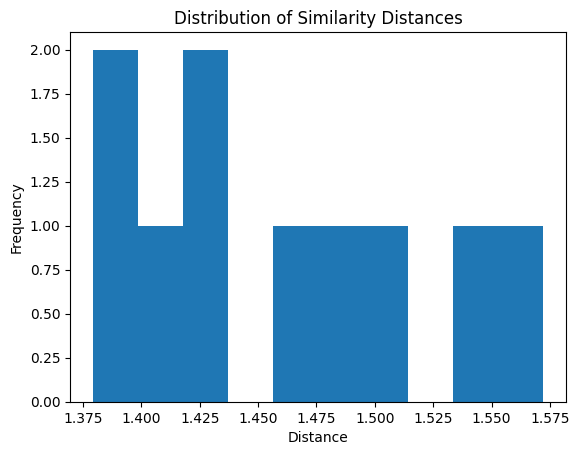

In [ ]:
import matplotlib.pyplot as plt

# Calculate statistics
print("Distance stats:")
print(results["distance"].describe())

# Plot the distribution
plt.hist(results["distance"], bins=10)
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Distances")
plt.show()


In [ ]:
import os
import pandas as pd

folder_path = "/content/drive/My Drive/E-commerce_Analysis/data/raw"

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        csv_path = os.path.join(folder_path, filename)
        # Read only the header row (nrows=0) to speed up processing
        df = pd.read_csv(csv_path, nrows=0)
        print(f"File: {filename}")
        print("Columns:", df.columns.tolist())
        print("-" * 60)


File: olist_geolocation_dataset.csv
Columns: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
------------------------------------------------------------
File: olist_order_payments_dataset.csv
Columns: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
------------------------------------------------------------
File: olist_order_items_dataset.csv
Columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
------------------------------------------------------------
File: olist_customers_dataset.csv
Columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
------------------------------------------------------------
File: olist_order_reviews_dataset.csv
Columns: ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'r

In [ ]:
# After running your search & filtering:
query = "pink t-shirt with monkey logo in m size"
results = search_products(query, model, index, df, top_k=10)
results_filtered = filter_by_price(results, 10.0, 50.0)
results_filtered = filter_by_distance(results_filtered, 1.5)
valid_categories = ["roupa", "t-shirt", "vestido", "jeans", "fashion"]
results_filtered = filter_by_category(results_filtered, valid_categories)
print("Final candidate results:")
print(results_filtered[["product_id", "original_text", "price", "distance"]])


IndexError: positional indexers are out-of-bounds